# Math 10 Final Project, 21 Spring
### Austin Zhong 91768718

## Task 1: Loading the data

In [1]:
import numpy as np
import pandas as pd
train_data = pd.read_csv('sign_mnist_train.csv')
test_data = pd.read_csv('sign_mnist_test.csv')

In [2]:
'Train and test'
X_train = train_data.drop(columns = 'label').to_numpy() # shape 
y_train = train_data['label'].to_numpy() # shape (N,)
X_test = test_data.drop(columns= 'label').to_numpy() # shape 
y_test = test_data['label'].to_numpy() # shape (N,)

In [3]:
'X and y'
frames = [train_data,test_data]
all_dataset = pd.concat(frames)
X = all_dataset.drop(columns="label").to_numpy() # (X,y) will eventually be used for unsupervised methods
y = all_dataset[["label"]].to_numpy().ravel()

In [3]:
'shape'
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(27455, 784) (27455,) (7172, 784) (7172,)


In [231]:
'numpy array formatting for image processing'
no_dup = all_dataset.drop_duplicates(subset=['label']) # remove duplicate rows
asc=no_dup.sort_values(by='label',ascending=True) # have rows be in alphabetical order
pixel_data = asc.drop(columns="label")
pixel_num = pixel_data.to_numpy()

L=[] # L has length 24 because J and Z are not not included in the dataset (gesture motions)
for row in range(len(pixel_num)):
    z = pixel_num[row].reshape((28,28))
    L.append(z)

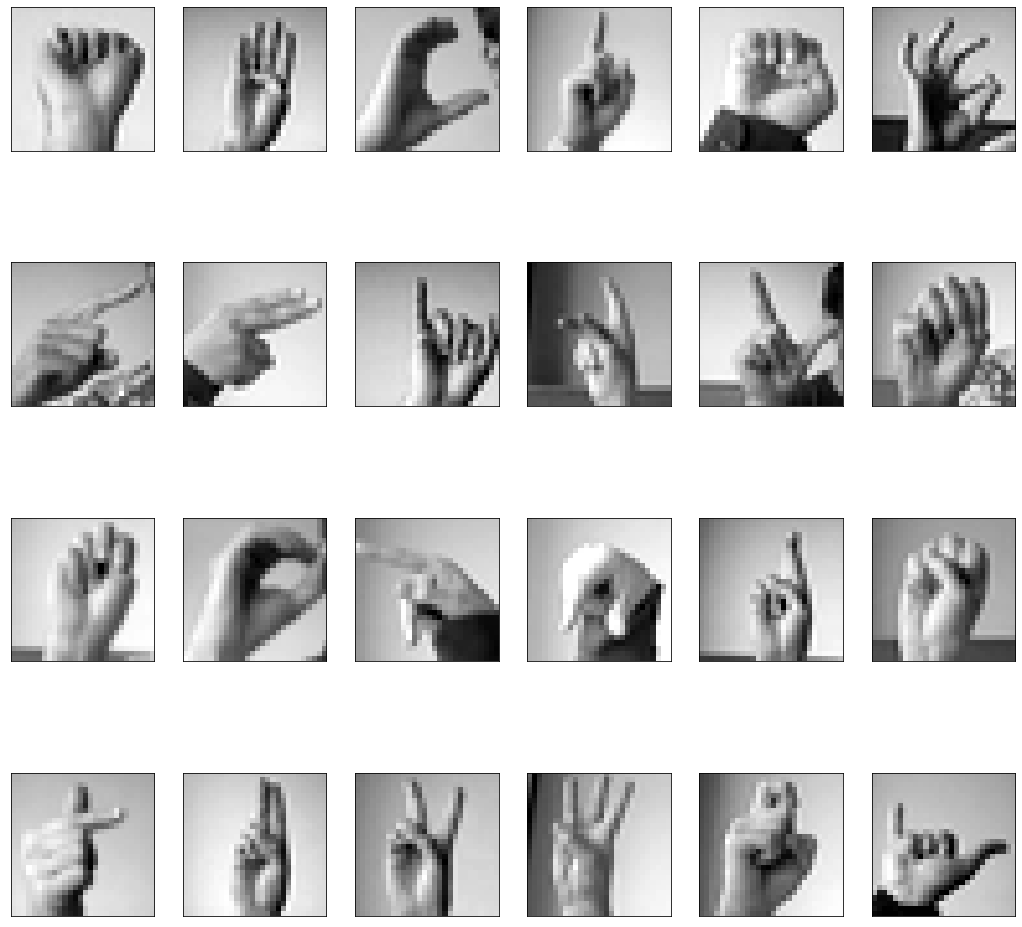

In [235]:
'image processing'
plt.figure(figsize=(18,18)) # specifying the overall grid size

for i in range(24):
    plt.subplot(4,6,i+1)    # the number of images in the grid is 4*6 (24)
    plt.imshow(L[i], plt.get_cmap('gray'))
    plt.gca().axes.get_xaxis().set_visible(False) # remove axis labels and ticks
    plt.gca().axes.get_yaxis().set_visible(False)
    
plt.show()

## Task 2: Logistic Regression

In [5]:
class myLogisticRegression():
    """ 
    Logistic Regression classifier 
    
    Parameters:
    ----------
        learning_rate: float
            The step length that will be taken when following the negative gradient during
        training.
        
        opt_method: strings "GD" or "SGD"
            Choose optimization method between gradient descent and stochastic gradient descent
    
        num_epochs: int
            number of passes through the entire training dataset
        
        size_batch: int
            number of training samples to work through before the model’s internal parameters are updated
    
    """
    def __init__(self, learning_rate=.001, opt_method = 'SGD', num_epochs = 50, size_batch = 20):
    
        # learning rate can also be in the fit method
        self.learning_rate = learning_rate
        self.opt_method = opt_method
        self.num_epochs = num_epochs
        self.size_batch = size_batch
        

    def fit(self, data, y, n_iterations = 1000):
        ''' 
        fit the model according to training data. specify "GD" or "SGD" and number of iterations
        
        Parameters:
        ----------
            data : 2-D numpy array with shape (n samples, n_features) from training data
            y : 1-D numpy array with shape (n samples,) from training data
            n_iterations : number iterations
        
        Returns:
        -------
            loss float after e epochs and i iterations 
        
        '''
        self.K = max(y)+1 # specify number of classes in y
        ones = np.ones((data.shape[0],1)) # column of ones 
        X = np.concatenate((ones, data), axis = 1) # the augmented matrix, \tilde{X} in our lecture
        eta = self.learning_rate
        
        W  = np.zeros((np.shape(X)[1],max(y)+1)) # initialize beta, can be other choices

        if self.opt_method == 'GD':
            for k in range(n_iterations):
                dW = self.loss_gradient(W,X,y) # write another function to compute gradient
                W = W - eta * dW # the formula of GD
                # this step is optional -- just for inspection purposes
                if k % 500 == 0: # print loss every 500 steps
                    print("loss after", k+1, "iterations is: ", self.loss(W,X,y))
        
        if self.opt_method == 'SGD':
            N = X.shape[0]
            num_epochs = self.num_epochs
            size_batch = self.size_batch
            num_iter = 0
            for e in range(num_epochs):
                shuffle_index = np.random.permutation(N) # in each epoch, we first reshuffle the data to create "randomness"
                for m in range(0,N,size_batch):   # m is the starting index of mini-batch
                    i = shuffle_index[m:m+size_batch] # index of samples in the mini-batch
                    dW = self.loss_gradient(W,X[i,:],y[i]) # only use the data in mini-batch to compute gradient. Note the average is taken in the loss_gradient function
                    W = W - eta * dW # the formula of GD, but this time dbeta is different
                
                    if e % 1 == 0 and num_iter % 50 ==0: # print loss during the training process
                        print("loss after", e+1, "epochs and ", num_iter+1, "iterations is: ", self.loss(W,X,y))
        
                    num_iter = num_iter +1  # number of total iterations
            
        self.coeff = W
        
    def predict(self, data):
        ''' 
        predict the output values (label number) for the input value data, based on trained parameters
        
        Parameters:
        ----------
            data : 1-D numpy array from training or test data
        
        Returns:
        -------
            1-D numpy array of same shape of as input, the predicted label number of corresponding dat
        '''
        ones = np.ones((data.shape[0],1)) # column of ones 
        X = np.concatenate((ones, data), axis = 1) # the augmented matrix, \tilde{X} in our lecture
        W = self.coeff # the estimated W
        y_pred = np.argmax(self.sigma(X,W), axis =1) # the category with largest probability
        return y_pred
    
    def score(self, data, y_true):
        '''
        Return the mean accuracy on the given test data and labels.
        
        Parameters:
        ----------
            data : 2-D numpy array with shape (n samples, n_features) from training or test data
            y_true : 1-D numpy array with shape (n samples,) from training or test data
            
        Returns:
        -------
            float acc, number of correct predictions divided by total number of predictions
        
        '''
        ones = np.ones((data.shape[0],1)) # column of ones 
        X = np.concatenate((ones, data), axis = 1) # the augmented matrix, \tilde{X} in our lecture
        y_pred = self.predict(data)
        acc = np.mean(y_pred == y_true) # number of correct predictions/N
        return acc
    
    def sigma(self,X,W): #return the softmax probability
        '''
        calculate softmax probability
        
        Parameters:
        ----------
            X : augmented data matrix with shape (n samples, n_features + 1)
            W : self.coeff 
        
        Returns:
        -------
            float softmax probability 
        '''
        s = np.exp(np.matmul(X,W))
        total = np.sum(s, axis=1).reshape(-1,1)
        return s/total
    
    def loss(self,W,X,y):
        '''
        calculate loss given inputs W, X, and y
        
        Parameters:
        ----------
            W : self.coeff
            X : augmented data matrix with shape (n samples, n_features + 1)
            y : 1-D numpy array with shape (n samples,) from training dataset
            
        Returns:
        -------
            float loss
        '''
        f_value = self.sigma(X,W)
        K = self.K 
        loss_vector = np.zeros(X.shape[0])
        for k in range(K):
            loss_vector += np.log(f_value+1e-10)[:,k] * (y == k) # avoid nan issues
        return -np.mean(loss_vector)
                          
    def loss_gradient(self,W,X,y):
        '''
        calculate loss gradient given inputs W, X, and y
        
        Parameters:
        ----------
            W : self.coeff
            X : augmented data matrix with shape (n samples, n_features + 1)
            y : 1-D numpy array with shape (n samples,) from training dataset
            
        Returns:
        -------
            loss gradient
        '''
        f_value = self.sigma(X,W)
        K = self.K 
        dLdW = np.zeros((X.shape[1],K))
        for k in range(K):
            dLdWk =(f_value[:,k] - (y==k)).reshape(-1,1)*X # Numpy broadcasting
            dLdW[:,k] = np.mean(dLdWk, axis=0)   # RHS is 1D Numpy array -- so you can safely put it in the k-th column of 2D array dLdW
        return dLdW

In [6]:
lg_sgd = myLogisticRegression(learning_rate=1e-6, opt_method = 'SGD', num_epochs = 15, size_batch = 40)

In [7]:
%%time
lg_sgd.fit(X_train,y_train)

loss after 1 epochs and  1 iterations is:  3.500510839779929
loss after 1 epochs and  51 iterations is:  2.9855200203986385
loss after 1 epochs and  101 iterations is:  2.9680185699679495
loss after 1 epochs and  151 iterations is:  2.771958461208642
loss after 1 epochs and  201 iterations is:  2.2725795558031106
loss after 1 epochs and  251 iterations is:  2.404369453362727
loss after 1 epochs and  301 iterations is:  2.1597858087587527
loss after 1 epochs and  351 iterations is:  2.1808776642471503
loss after 1 epochs and  401 iterations is:  1.9754450563094128
loss after 1 epochs and  451 iterations is:  1.8707718796944666
loss after 1 epochs and  501 iterations is:  1.7779568262476284
loss after 1 epochs and  551 iterations is:  1.8187242909354153
loss after 1 epochs and  601 iterations is:  1.8524170915512561
loss after 1 epochs and  651 iterations is:  1.5955525319070147
loss after 2 epochs and  701 iterations is:  1.7221469178662676
loss after 2 epochs and  751 iterations is:  1

loss after 10 epochs and  6351 iterations is:  0.602644031460928
loss after 10 epochs and  6401 iterations is:  0.6461042978157315
loss after 10 epochs and  6451 iterations is:  0.596543774318304
loss after 10 epochs and  6501 iterations is:  0.5994821481707966
loss after 10 epochs and  6551 iterations is:  0.5959888363467267
loss after 10 epochs and  6601 iterations is:  0.5711439652906194
loss after 10 epochs and  6651 iterations is:  0.6034845204391441
loss after 10 epochs and  6701 iterations is:  0.5700805692064305
loss after 10 epochs and  6751 iterations is:  0.6018668994460178
loss after 10 epochs and  6801 iterations is:  0.5855417147805367
loss after 10 epochs and  6851 iterations is:  0.5932646348864113
loss after 11 epochs and  6901 iterations is:  0.5778228577338528
loss after 11 epochs and  6951 iterations is:  0.5770515427668208
loss after 11 epochs and  7001 iterations is:  0.5868849147183078
loss after 11 epochs and  7051 iterations is:  0.5954109195788584
loss after 1

In [10]:
lg_sgd.score(X_test,y_test)

0.6710819854991634

The logistical regression model scored 0.6710 on the test dataset which means it was 67.10% accurate in making predictions.

## Task 3: Principle Component Analysis

In [5]:
class myPCA():
    """
    Principle component analysis 
    
    Parameters:
    ----------
        n_components : integer, number of components to keep. if n_components is not set all components are kept
    
    """
    
    def __init__(self, n_components = 50):
        self.n_c = n_components
    
    
    def fit(self,X):
        """ 
        Fit the model with X.
        
        Parameters:
        ----------
            X : 2-D numpy aray with shape (n_samples, n_features) from training data
        
        Returns:
        -------
            self : object, the instance itself
        """
        cov_mat = np.cov(X.T) # covariance matrix, the input matrix to this function does not need to be centered
        eig_val, eig_vec = np.linalg.eigh(cov_mat) #eigen-values and orthogonal eigen-vectors --ascending order
        eig_val = np.flip(eig_val) # reverse the order --descending
        eig_vec = np.flip(eig_vec,axis=1) # reverse the order
        self.eig_values = eig_val[:self.n_c] # select the top eigen-vals
        self.principle_components = eig_vec[:,:self.n_c] # select the top eigen-vecs
        self.variance_ratio = self.eig_values/eig_val.sum() # variance explained by each PC
    
    def transform(self,X):
        """
        Apply the dimensionality reduction on X
        
        Parameters:
        ----------
            X : 2-D numpy aray with shape (n_samples, n_features) from training data
            
        Returns:
        -------
            X_new : ndarray of shape (n_samples, n_components), transformed values.
        """
        return np.matmul(X-X.mean(axis = 0),self.principle_components) #project the data (centered) on PCs

In [6]:
pca = myPCA(n_components = 15)
pca.fit(X)
X_pca = pca.transform(X)

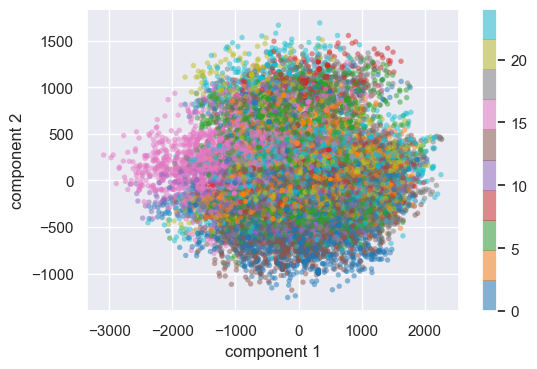

In [7]:
import matplotlib.pyplot as plt
figure = plt.figure(dpi=100)
plt.scatter(X_pca[:, 0], X_pca[:, 1],c=y, s=15, edgecolor='none', alpha=0.5,cmap=plt.cm.get_cmap('tab10', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar(); # True labels of each sign distinguished by different colors

## Task 4: Other Methods in Scikit-Learn

### [Decision Tree](https://en.wikipedia.org/wiki/Decision_tree_learning) (supervised method)
For this classification model, instead of using mathematical equations, we actually make a series of "decisions" based on the important features that are drawn from past experience. By repeatedly setting threshold for different features (multiple if-else conditions -- forming a flow-chart or decision tree structure), we can naturally achieve the classification task. The "leaves" repesent class labels and the "branches" represent conjunctions of features that lead to those class labels.
To decide the appropriate thresholds and the order of if-else conditions: Gini impurity or Entropy. These tresholds/order of conditions are determined by the training dataset, using certain metrics to select. Different concerete strategies lead to various algorithms, known as ID3, CART, C4.5...

**Algorithm:** The Gini impurity can be computed by summing the probability $p_{i}$ of an item with label $i$ being chosen times the probability $\sum_{k\neq i} 1-p_{i}$ of a mistake in categorizing that item. 
To compute Gini impurity for a set of items with $J$ classes, suppose $i \in {1,2,...,J}$, and let $p_{i}$ be the fraction of items labeled with class $i$ in the set.

$I_{G}(p)= \sum_{i = 1}^J (p_{i} \sum_{k \neq i} p_{k}) = \sum_{i = 1}^J p_{i}(1-p_{i}) = \sum_{i = 1}^J (p_{i}-p_{i}^2) = \sum_{i = 1}^J p_{i} - \sum_{i = 1}^J p_{i}^2 = 1 - \sum_{i = 1}^J p_{i}^2$

In [17]:
'Decision Tree'
from sklearn import tree
dt_clf = tree.DecisionTreeClassifier()
dt_clf.fit(X_train,y_train)
dt_clf.score(X_test,y_test)

0.4387897378694925

The decision tree method scored 0.4387, a much poorer score compared to logistic regression's score of 0.6710. This is most likely due to decision tree's tendency to over-fit and have high variance.

### [Isomap](https://en.wikipedia.org/wiki/Isomap) (unsupervised method)
Isomap is a nonlinear dimensionality reduction method. In high dimensional data, the  $𝑛×𝑛$  dissimilarity (distance) matrix  $𝑑_{𝑖𝑗}$  is chosen as the Geodesic distance on data manifold (imagine: shortest curve to connect two points on the surface). Classic multidimensional scaling is the used to embed the data into 2D space. The algorithm is as follows: determine the neighbors of each point (all points in some fixed radius, K nearest neighbors), construct a neighborhood graph
(each point is connected to other if it is a K nearest neighbor, edge length equal to Euclidean distance), compute shortest path between two nodes (Dijkstra's algorithm, Floyd–Warshall algorithm), compute lower-dimensional embedding (Multidimensional scaling). 

**Algorithm:** Classical MDS uses the fact that the coordinate matrix $X$ can be derived by eigenvalue decomposition from $B=XX'$. And the matrix $B$ can be computed from proximity matrix $D$ by using double centering.
 
1) Set up the squared proximity matrix $D^{(2)} = [d_{ij}^2]$

2) Apply double centering: $B=-\frac{1}{2}CD^{(2)}C$ using the centering matrix $C = I - \frac{1}{n}J_{n}$, where $n$ is the number of objects, $I$ is the $n\times n$ identity matrix, and $J_{n}$ is an $n\times n$ matrix of all ones.

3) Determine the $m$ largest eigenvalues $\lambda_{1},\lambda_{2},...,\lambda_{m}$ and corresponding eigenvectors $e_{1},e_{2},...,e_{m}$ of $B$ (where $m$ is the number of dimensions desired for the output).

4) Now, $X = E_{m}\Lambda_{m}^{1/2}$ , where $E_{m}$ is the matrix of $m$ eigenvectors and $\Lambda_{m}$ is the diagonal matrix of $m$ eigenvalues of $B$.

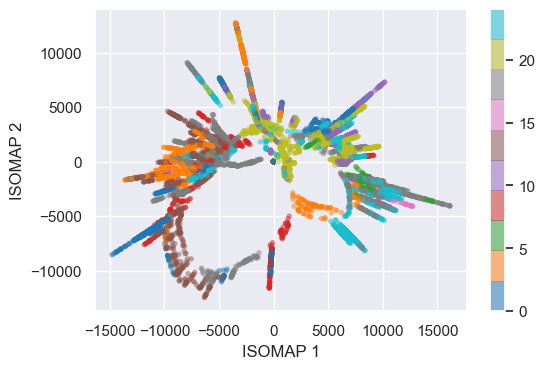

In [12]:
'Isomap'
from sklearn.manifold import Isomap
isomap = Isomap(n_jobs = -1)
X_isomap = isomap.fit_transform(X)

import seaborn as sns; sns.set()
figure = plt.figure(dpi=100)
plt.scatter(X_isomap[:, 0], X_isomap[:, 1],c=y, s=15, edgecolor='none', alpha=0.5,cmap=plt.cm.get_cmap('tab10', 10))
plt.xlabel('ISOMAP 1')
plt.ylabel('ISOMAP 2')
plt.colorbar();

## Task 5: Other Packages in Machine Learning

### Scikit-Learn [k-NN (k-nearest neighbor classifier)](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) (supervised method)
The k-NN algorithm assumes similar things are in close proximity to eachother. Given a test sample x from the test dataset, an object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors. For example, if k=1, then the test sample would be assigned to the class of the single nearest neighbor. If k=12, the test sample would be assigned to the class with the most neighbors out of the 12 closest ones. 

**Algorithm:** Given a test sample $x$ from test dataset, the kNN classifier first identifies the neighbors $k$ points in the training data that are closest to $\mathbf{x}$, whose indices are represented by $\mathcal{N}_{x}$. It then estimates the probability that $\mathbf{x}$ belongs to class $j$ by $P\big(y= j| \mathbf{x} \big)$ computing the fraction of points in $\mathcal{N}$ whose label(s) actually equal $j$:

$$
P\big(y= j| \mathbf{x} \big)\approx  \frac{1}{k} \sum_{i\in \mathcal{N}_{x}} 1\{ y^{(i)} = j\}.
$$

To determine the class, the algorithm chooses the one with the highest probability.

In [6]:
'kNN'
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors = 7)
knn_clf.fit(X_train, y_train)
knn_clf.score(X_test,y_test)

0.8017289459007251

k-NN outperformed logitical regression by a significant margin (over 10%).

### Scikit-Learn [Random Forest](https://en.wikipedia.org/wiki/Random_forest#:~:text=Random%20forests%20or%20random%20decision,average%20prediction%20(regression)%20of%20the) (supervised method)
Random forest is an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean/average prediction (regression) of the individual trees. Random subsets of features and samples are chosen as the training data set in each run (bootstrap aggregating). This bootstrapping procedure leads to better model performance because it decreases the variance of the model, without increasing the bias. 

**Algorithm:** Decision tree and bagging. Given a training set $X = x_{1}, ..., x_{n}$ with responses $Y = y_{1}, ..., y_{n}$, bagging repeatedly (B times) selects a random sample with replacement of the training set and fits trees to these samples:
For $b = 1, ..., B$:
1) Sample, with replacement, $n$ training examples from $X$, $Y$; call these $X_{b}$, $Y_{b}$.

2) Train a classification or regression tree $f_{b}$ on $X_{b}$, $Y_{b}$.

After training, predictions for unseen samples x' can be made by averaging the predictions from all the individual regression trees on $x'$:

$\hat{f} = \frac{1}{B} \sum_{b=1}^B f_{b}(x')$

or by taking the majority vote in the case of classification trees.

Additionally, an estimate of the uncertainty of the prediction can be made as the standard deviation of the predictions from all the individual regression trees on $x'$:

$\sigma = \sqrt{\frac{\sum_{b=1}^B (f_{b}(x')-\hat{f})^2}{B-1}}$

In [39]:
'Random Forest'
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=1000, max_samples = 0.5, max_depth=50, max_features=500, random_state=0, n_jobs = -1) # make 1000 decision trees by random picking up 90% of the dataset, and each tree has the maximum depth of 5. njobs = -1 means to use all the processors of computer
rf_clf.fit(X_train, y_train) 
rf_clf.score(X_test, y_test)

0.7854155047406581

The random forest method outperformed both logistic regression (0.6710) and decision tree (0.4387).

### Scikit-Learn [K-Means Clustering](https://en.wikipedia.org/wiki/K-means_clustering) (unsupervised method)
k-means clustering is a method of vector quantization, that searches for a pre-determined number of clusters within an unlabeled multidimensional dataset. k-means clustering has a loose relationship to knn. Applying the 1-nearest neighbor classifier to the cluster centers obtained by k-means classifies new data into the existing clusters.

**Algorithm:** Given a set of observations $(x^{(1)}, x^{(2)}, ..., x^{(n)})$, where each observation is a p-dimensional real vector, k-means clustering aims to partition the $n$ samples into $K (\leq n)$ sets $S = {S_1, S_2, ..., S_K}$ so as to minimize the within-cluster sum of squares (i.e. variance). Formally, the objective is to find the best parition of groups such that minimize the "loss function" of $S$

$$\min_{S}\sum_{i=1}^{K}\sum_{x\in S_{i}}\|x-\mu_{i}\|^{2}$$

where $\mu_{i}$ is the mean of points in $S_i$. To evaluate the perfornamce of the model, Adjusted Rand Index is used.

In [8]:
'k-means clustering'
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=24, random_state=0) # 24 labels
y_km = kmeans.fit_predict(X)

Text(0.5, 1.0, 'True Labels')

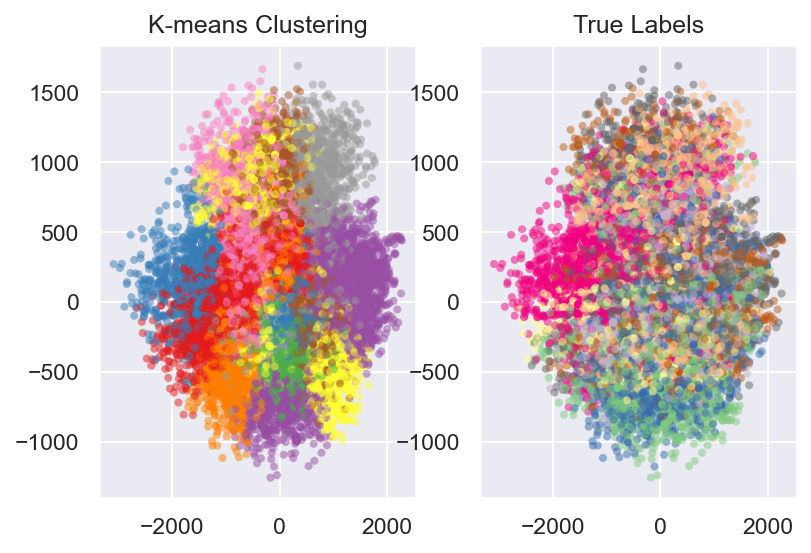

In [37]:
import seaborn as sns; sns.set()
fig, (ax1, ax2) = plt.subplots(1, 2,dpi=150)

fig1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1],c=y_km, s=15, edgecolor='none', alpha=0.5,cmap=plt.cm.get_cmap('Set1', 24))
fig2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1],c=y, s=15, edgecolor='none', alpha=0.5,cmap=plt.cm.get_cmap('Accent', 24))
ax1.set_title('K-means Clustering')
ax2.set_title('True Labels') # True labels of each sign distinguished by different colors